# Blood Group Detection from Fingerprint using ResNet50

#### Import the required libraries

In [1]:
import os
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
import zipfile
import warnings
warnings.filterwarnings('ignore')

#### Download and unzip the dataset

In [2]:
!kaggle datasets download -d rajumavinmar/finger-print-based-blood-group-dataset

Dataset URL: https://www.kaggle.com/datasets/rajumavinmar/finger-print-based-blood-group-dataset
License(s): unknown
100% 58.0M/58.1M [00:03<00:00, 24.3MB/s]
100% 58.1M/58.1M [00:03<00:00, 16.9MB/s]


In [3]:
zip_ref = zipfile.ZipFile('/content/finger-print-based-blood-group-dataset.zip')
zip_ref.extractall('/content')
zip_ref.close()

#### Data preprocessing

In [3]:
file_path = '/content/dataset_blood_group'

In [4]:
data = pd.DataFrame({
    'Filepath': glob.glob(file_path + "/*/*"),
    'Label': [os.path.basename(os.path.dirname(fp)) for fp in glob.glob(file_path + "/*/*")]
})

#### Splitting the dataset into train and test sets

In [5]:
train, test = train_test_split(data, test_size=0.20, random_state=42, stratify=data["Label"])

#### Image data augmentation

In [6]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(256, 256),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_gen = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(256, 256),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 4800 validated image filenames belonging to 8 classes.
Found 1200 validated image filenames belonging to 8 classes.


#### Model architecture

In [7]:
pretrained_model = ResNet50(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [8]:
inputs = pretrained_model.input
x = Dense(128, activation='relu')(pretrained_model.output)
x = Dense(128, activation='relu')(x)
outputs = Dense(8, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,867,528 (91.05 MB)

 Trainable params: 279,816 (1.07 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

#### Model training

In [9]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=20
)

Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 46s 194ms/step - accuracy: 0.4298 - loss: 1.4796 - val_accuracy: 0.6208 - val_loss: 0.9663
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.6813 - loss: 0.8079 - val_accuracy: 0.7467 - val_loss: 0.6742
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 129ms/step - accuracy: 0.7529 - loss: 0.6426 - val_accuracy: 0.7375 - val_loss: 0.6578
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 132ms/step - accuracy: 0.7810 - loss: 0.5616 - val_accuracy: 0.7617 - val_loss: 0.5924
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 129ms/step - accuracy: 0.7961 - loss: 0.5015 - val_accuracy: 0.7333 - val_loss: 0.7162
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.8279 - loss: 0.4426 - val_accuracy: 0.7892 - val_loss: 0.5230
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.8580 - loss: 0.3796 - val_accuracy: 0.7925 - val_loss: 0.5541
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 127ms/step - accuracy: 0.8645 - loss: 0

#### Saving the model

In [10]:
model.save("resnet50.h5")

#### Model evaluation

In [11]:
name_class = sorted(os.listdir(file_path))
pred = model.predict(valid_gen)
pred_labels = np.argmax(pred, axis=1)
true_labels = valid_gen.classes

print(classification_report(true_labels, pred_labels, target_names=name_class))

38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 221ms/step
              precision    recall  f1-score   support

          A+       0.99      0.75      0.85       113
          A-       0.85      0.76      0.80       202
         AB+       0.74      0.85      0.79       142
         AB-       0.84      0.81      0.83       152
          B+       0.76      0.85      0.80       130
          B-       0.90      0.90      0.90       148
          O+       0.84      0.78      0.81       171
          O-       0.67      0.83      0.74       142

    accuracy                           0.81      1200
   macro avg       0.83      0.82      0.82      1200
weighted avg       0.82      0.81      0.82      1200



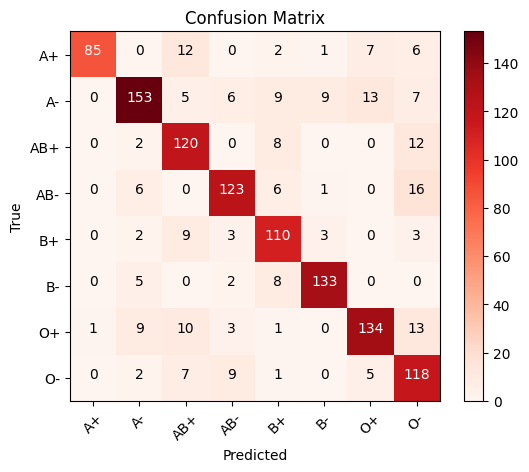

In [12]:
cm = confusion_matrix(true_labels, pred_labels)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(name_class))
plt.xticks(tick_marks, name_class, rotation=45)
plt.yticks(tick_marks, name_class)

for i in range(len(name_class)):
    for j in range(len(name_class)):
        plt.text(j, i, str(cm[i, j]), horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#### Visualizing accuracy and loss over epochs

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

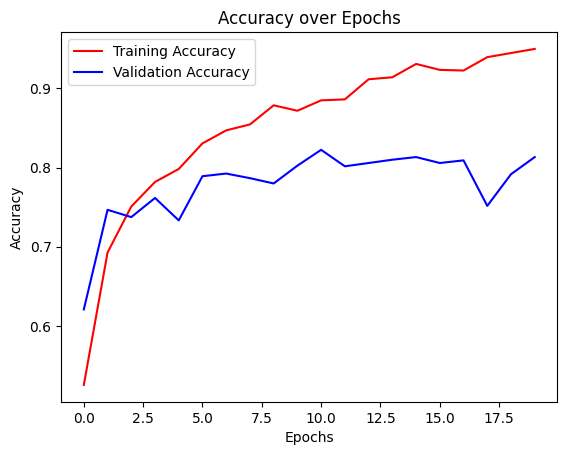

In [14]:
plt.plot(epochs_range, acc, label='Training Accuracy', color='red')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='blue')
plt.legend(loc=0)
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

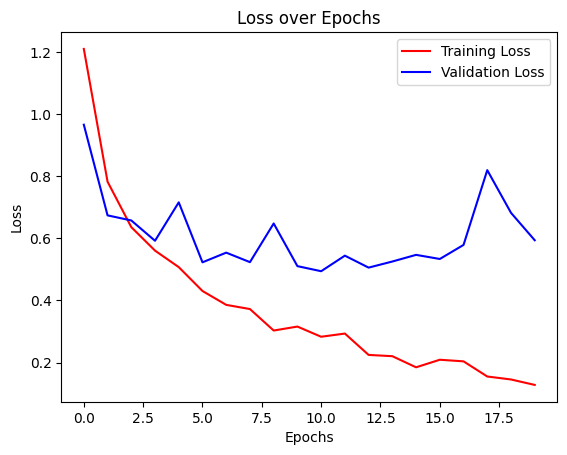

In [15]:
plt.plot(epochs_range, loss, label='Training Loss', color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='blue')
plt.legend(loc=0)
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

#### Model prediction

In [16]:
class_names = ['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']

def predict_blood_group(image_path, model, class_names):
    img = image.load_img(image_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_names[predicted_class_index]
    confidence_score = np.max(predictions) * 100

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_class}\nConfidence: {confidence_score:.2f}%", fontsize=14, color='black')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


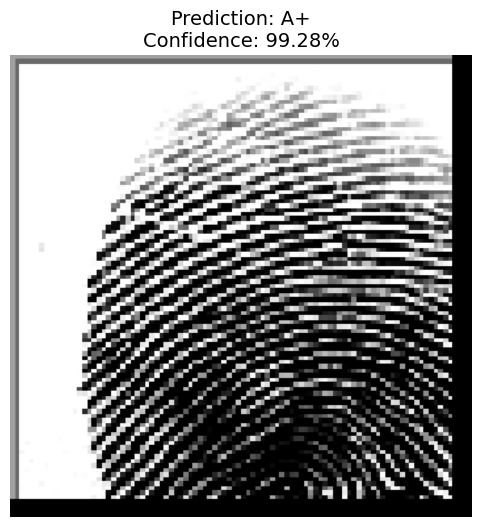

In [17]:
image_path = '/content/dataset_blood_group/A+/cluster_0_1001.BMP'
predict_blood_group(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


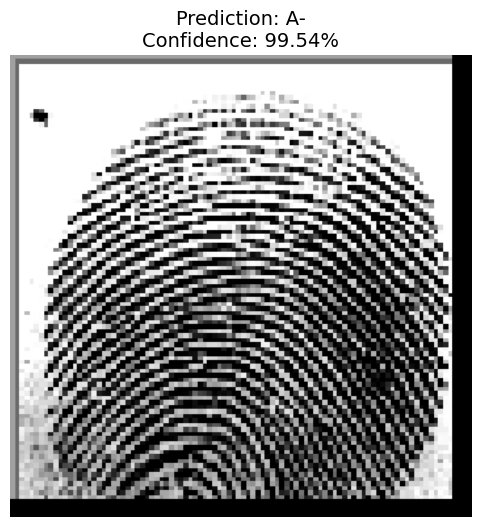

In [18]:
image_path = '/content/dataset_blood_group/A-/cluster_1_1007.BMP'
predict_blood_group(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


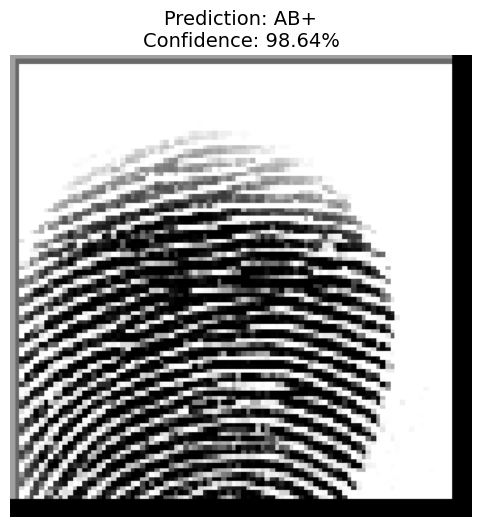

In [19]:
image_path = '/content/dataset_blood_group/AB+/cluster_4_100.BMP'
predict_blood_group(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


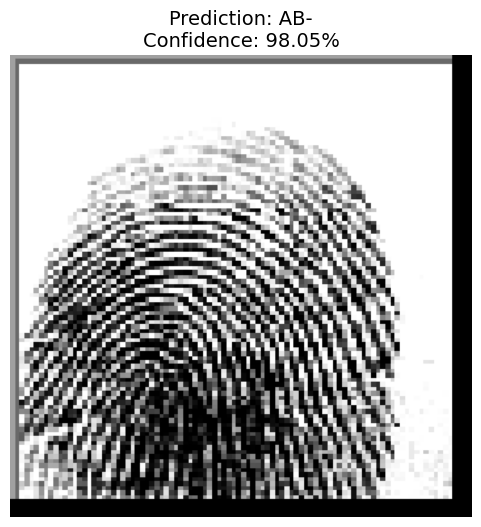

In [24]:
image_path = '/content/dataset_blood_group/AB-/cluster_5_1052.BMP'
predict_blood_group(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


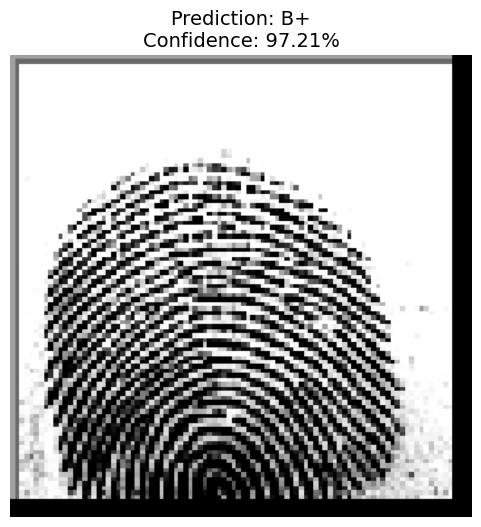

In [20]:
image_path = '/content/dataset_blood_group/B+/cluster_2_1077.BMP'
predict_blood_group(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


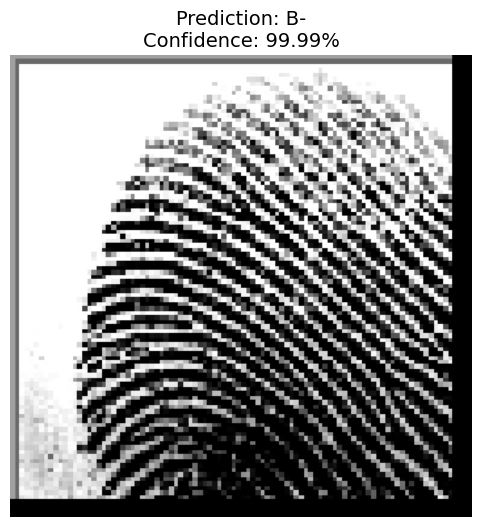

In [21]:
image_path = '/content/dataset_blood_group/B-/cluster_3_1018.BMP'
predict_blood_group(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


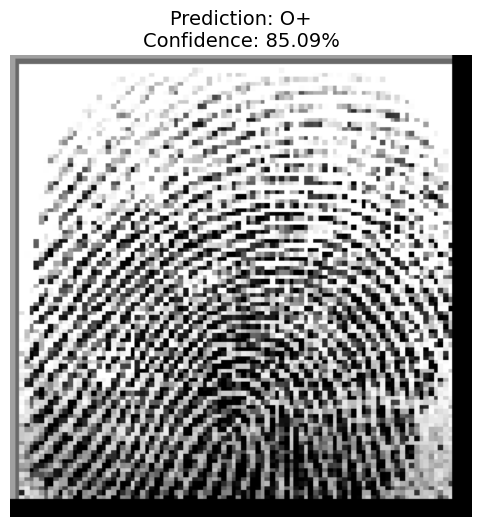

In [22]:
image_path = '/content/dataset_blood_group/O+/cluster_6_1004.BMP'
predict_blood_group(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


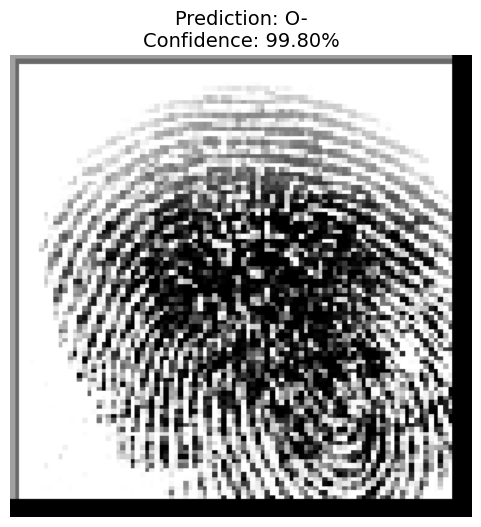

In [23]:
image_path = '/content/dataset_blood_group/O-/cluster_7_1177.BMP'
predict_blood_group(image_path, model, class_names)